In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS =10
BS = 32

In [3]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    if(label!="without_mask"):
        label="with_mask"

	# load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

	# update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [4]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [5]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [6]:
# left off
baseModel = VGG19(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [7]:
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [8]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [9]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] training head...
Epoch 1/10
41/41 [==============================] - 485s 12s/step - loss: 1.6168 - accuracy: 0.6873 - val_loss: 0.3895 - val_accuracy: 0.8839
Epoch 2/10
41/41 [==============================] - 596s 15s/step - loss: 0.8521 - accuracy: 0.8043 - val_loss: 0.2179 - val_accuracy: 0.9315
Epoch 3/10
41/41 [==============================] - 919s 22s/step - loss: 0.4864 - accuracy: 0.8624 - val_loss: 0.1430 - val_accuracy: 0.9524
Epoch 4/10
41/41 [==============================] - 843s 21s/step - loss: 0.4045 - accuracy: 0.8998 - val_loss: 0.0892 - val_accuracy: 0.9673
Epoch 5/10
41/41 [==============================] - 659s 16s/step - loss: 0.3471 - accuracy: 0.9014 - val_loss: 0.0747 - val_accuracy: 0.9702
Epoch 6/10
41/41 [==============================] - 809s 20s/step - loss: 0.2739 - accuracy: 0.9215 - val_loss: 0.0665 - val_accuracy: 0.9702
Epoch 7/10
41/41 [==============================] - 1067s 26s/step - loss: 0.1810 - accuracy: 0.9411 - val_loss: 0.0449 - va

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       198
without_mask       0.99      0.96      0.98       138

    accuracy                           0.98       336
   macro avg       0.98      0.98      0.98       336
weighted avg       0.98      0.98      0.98       336

[INFO] saving mask detector model...


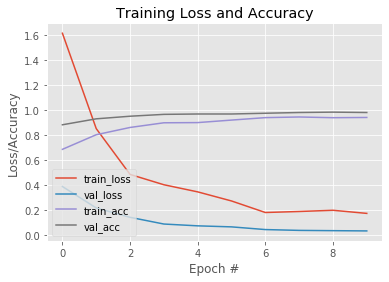

In [16]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model_vgg19.h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("vgg19graph.jpg")
plt.show()


In [15]:
plt.savefig("resultvgg19.pdf")

<Figure size 432x288 with 0 Axes>

In [12]:
testY.shape

(336, 2)